# Preliminary analysis

We are interested in understanding if micro-contributions are associated with more substantial contributions to Wikimedia. By "micro-contributions", we mean small contributions that typically are available through other interfaces than the standard editor. Examples include [description edits](https://www.mediawiki.org/wiki/Wikimedia_Apps/Short_descriptions) and [structured captions](https://commons.wikimedia.org/wiki/Commons:Structured_data/Overview). By "more substantial contributions" we mean editing Wikipedia articles. Description edits can be done through the Android app, and structured captions will be suggested in v2 of [Suggested Edits](https://www.mediawiki.org/wiki/Wikimedia_Apps/Team/Android/AppEditorTasks). Note that description edits are already available in Suggested Edits.

Some key timeline events to note are:

* 2017-01-15: Description editing available in alpha only.
* 2017-02-09: Description editing available in beta in Russian, Hebrew, and Catalan.
* 2017-02-27: Description editing available in production in Russian, Hebrew, and Catalan.
* 2017-04-24: Description editing rolled out in more languages.
* 2017-07-05: Description editing available for all languages except English.
* 2019-01-xx: File captions released on Commons.
* 2019-04-23: Depicts statements released on Commons.

Sources for these dates: [HaeB's PAWS notebook of description edits](http://paws-public.wmflabs.org/paws-public/User:HaeB/Mobile%20app%20edits%20on%20Wikidata%20-%20reverts%20analysis.ipynb), [Commons:Depicts](https://commons.wikimedia.org/w/index.php?title=Commons:Depicts&oldid=359967475) for the depicts release date, and [Commons:File captions](https://commons.wikimedia.org/w/index.php?title=Commons:File_captions&oldid=352651956) for the file captions release date.

Description editing on English Wikipedia is different from the other wikis. Instead of using Wikidata for all decriptions, they can locally override it with the "shortdesc" magic word (which seems to be in frequent use). See for example [this RfC](https://en.wikipedia.org/wiki/Wikipedia:Village_pump_(proposals)/Archive_138#Rfc:_Remove_description_taken_from_Wikidata_from_mobile_view_of_en-WP) and [this phab task](https://phabricator.wikimedia.org/T184000) for more information.


In [1]:
import pandas as pd

from wmfdata import hive

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [11]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [12]:
%%R
library(ggplot2)
library(data.table)

## Notes

Based on the previous notebooks, it looks like description edits are edits to Wikidata tagged with "app edit" (or something like that).

**TODO:** I'll need to look at what other types of edit tags are available on Wikidata, and also on Commons.

We don't know who the users who are making these edits are. I'll have to look at things like account age and number of edits prior to a user's first description edit. Same for Commons and Structured Data, who are the users who are editing that?

I'll have to figure out how to determine if an edit on Commons was SDC or not (might be edit tags mentioned above).

There's also a lingering question behind this, to what extent are *new* users making micro-contributions? We might want to know specifically if users create accounts and start making micro-contributions.

One question I'll have to try to answer is whether we care about Wikipedia *article* edits as the definition of "more substantial contributions", or whether we also count Commons and Wikidata edits in general.

I also need to figure out how centralize accounts. After digging around in the databases for a while, I think I've come to the conclusion that 1) all queries should be run against the Data Lake so data for all wikis is available, and 2) accounts are aligned so a user has the same username across all wikis. This means that I'll use usernames to identify what wikis a user might have accounts on, when their account was created (minimum of all), whehter they've made edits to other wikis, etc…

### Retention

Based on the dates above it's clear that micro-contributions haven't been around for very long. This means that when it comes to retention and conversion of new users, we're unable to determine long-term retention for other types of edits. To get some numbers, we might want to look at second-month retention of users who start out with micro-contributions.

## Edit tags

I want an overview of the edit tags available on Commons and on Wikidata, and to what extent they've been used, say in 2018 and 2019.

First, I looked through [Special:Tags on Commons](https://commons.wikimedia.org/wiki/Special:Tags) and noticed the "Short caption" tag, which means the edit was of a [file caption](https://commons.wikimedia.org/wiki/Commons:File_captions). Those were the first part of SDC to be enabled in early 2019.

Digging further into recent changes on Commons, I found a caption being added with the edit comment "Added [de] caption", where "[de]" is the language (German in this case, I've also seen English). Looks like "depicts" are added as "Created claim: (d:P180):" followed by a link to Wikidata to the item it depicts. The "(d:P180)" is a link to the deptics property on Wikidata. If a claim is edited, the comment instead reads "Changed claim:" followed by the same style of comment. An example edit history with both types of edits is: https://commons.wikimedia.org/w/index.php?title=File:Nancy_Houk_with_plates_for_transfer.jpg&action=history

So it looks like I'll have to dig into some edit comments to figure out what claims are commonly used, because "depicts" might not be the only one. I'll also get some monthly stats on usage of "Added [xx] caption" to count all captions. At this point we might not be interested in what language was added, but we might as well prepare to have to answer that question.

I looked through [Special:Tags on Wikidata](https://www.wikidata.org/wiki/Special:Tags), but didn't find anything in particular that stood out. This suggests that for Wikidata, I might just use the mobile app edit tag that I found in HaeB's earlier.

In order to make things clearer, I looked through the list of edits tagged with "mobile app edit", and it looks like I should filter out edits tagged with "Wikimedia Commons app" in order to not count Commons-work as Wikidata-work, and because the edits done by that are different, they do not appear to be description edits. Looks like I can also use edit comments to identify proper description edits, as the comment says "Added [{langcode}] description:" or "Changed {langname} description" (why is the language code used in the first but the name of the language used in the second?)

## Next up

User analysis. Who are the users who are making these edits, are they newcomers or experienced?

We want to do this for both description edits on Wikidata, and for structured data edits on Commons. For these users we want to know:

1. What is the global age of the user when they made their first edit?
2. Do these users tend to be labelled as an active editor?
3. Of the users who are labelled as active editors, are they labelled as "new active editors"?

Then later I want to move on to see whether users who start out doing this will move on to making other types of edits.

For the first question, I want to know this across time, plot percentiles: 10th, 25th, 50th, 75th, 90th. Maybe also min and max. Plot it on a log scale.

For the second question, we are just looking at edits per month, and I want to know what proportion of users who made at least one edit went on to be labelled "active editor" that month.

Then, for the last question, I want to know if their account was created during that month.

Maybe just count the number of users who do this type of work who are labelled as "new active editor"? I think knowing if that number is increasing is also interesting.

## Description edits on Wikidata

I want to know how many description edits have been done on Wikidata, per month, since 2017. To do this, we count the number of edits tagged with "mobile app edit", but I'll also check if the edit was tagged with "Wikimedia Commons app" in order to be able to control for that. Lastly, I'll check if the edit was reverted within 48 hours, and be able to calculate a revert rate.

In [8]:
description_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month,
       COUNT(*) AS num_app_edits,
       SUM(IF(array_contains(revision_tags, "wikimedia-commons-app") = TRUE, 1, 0)) AS commons_edits,
       SUM(IF(revision_is_identity_reverted = TRUE
              AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverts
FROM wmf.mediawiki_history
WHERE snapshot = "2019-07"
AND wiki_db = "wikidatawiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2017-01-01"
AND array_contains(revision_tags, "mobile app edit") = TRUE
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01")
LIMIT 250
'''

In [9]:
description_edits = hive.run(description_query)

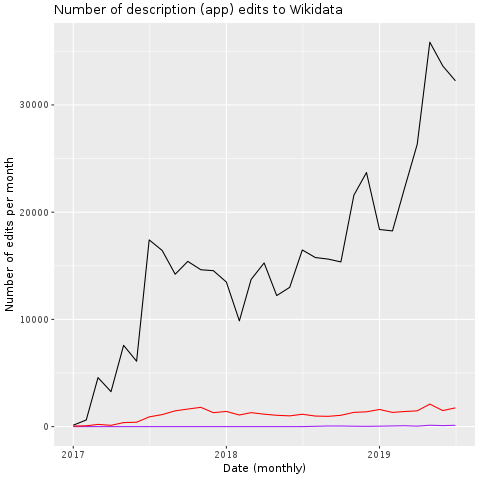

In [20]:
%%R -i description_edits

## Let's make a graph!
description_edits = data.table(description_edits)
description_edits[, log_month := as.Date(log_month)]

ggplot(description_edits[log_month < '2019-08-01'],
       aes(x = log_month, y = num_app_edits)) +
ggtitle("Number of description (app) edits to Wikidata") +
scale_x_date('Date (monthly)') +
scale_y_continuous('Number of edits per month') +
geom_line() +
geom_line(aes(y = commons_edits), colour = "purple") +
geom_line(aes(y = num_reverts), colour = "red")


What we see from the graph above is that the number of Commons app edits (shown in purple) is very small compared to the number of other edits and we might therefore choose to just ignore it. Secondly, we can see that while the number of description edits has increased dramatically over time, the number of reverts (shown in red) has not. It is instead largely stable, indicating that description edits are high quality edits.

## Claims on Commons

While Commons has the "Short description" edit tag that allows us to identify description edits, there are also the "depicts" edits that are identifiable through edit comments. In order to understand what types of edits are available, we mine all edit comments on Commons for three pieces of information:

1. Whether the edit creates or changes a claim (either "wbsetclaim-create:" or "wbsetclaim-update" in the edit comment).
3. The Wikidata property that is set (e.g. P180 is "depicts").

In order to do this, we have to get a dataset of all edit comments and parse the comment ourselves as it looks like we run into differences between Hive and Spark when it comes to regular expressions that somehow means we can't extract content as we want.

In [61]:
## Grab edit comments for all edits that created or updated a claim

claim_comments_query = """
SELECT event_comment
FROM wmf.mediawiki_history
WHERE snapshot = '2019-07'
AND wiki_db = 'commonswiki'
AND event_entity = 'revision'
AND event_type = 'create'
AND event_timestamp >= '2017-01-01'
AND event_timestamp < '2019-08-01'
AND event_comment REGEXP 'wbsetclaim-(create|update)'
"""

In [62]:
claim_comments = hive.run(claim_comments_query)

In [63]:
## just checking to make sure I got data
claim_comments.head()

,event_comment
0,/* wbsetclaim-create:2||1 */ [[d:Special:Entit...
1,/* wbsetclaim-update:2||1 */ [[d:Special:Entit...
2,/* wbsetclaim-update:2||1|1 */ [[d:Special:Ent...
3,/* wbsetclaim-update:2||1 */ [[d:Special:Entit...
4,/* wbsetclaim-create:2||1 */ [[d:Special:Entit...


In [64]:
## function to map over event comments and add columns for add/update and the property changed
import re

def extract_claim_info(row):
    '''
    Extract information about whether a claim was added or updated, and what claim specifically
    was added/updated.
    '''
    edit_type = None
    claim = None
    
    match = re.match("...wbsetclaim-(create|update):.*?Special:EntityPage/(P\d+)", row.event_comment)
    if match:
        edit_type = match.group(1)
        claim = match.group(2)
    
    return(pd.Series([edit_type, claim]))

In [65]:
claim_comments[['edit_type', 'claim']] = claim_comments.apply(extract_claim_info, axis=1)

In [72]:
## Let's count them up and see if we need to look at other types of edits

(claim_comments.groupby(['edit_type', 'claim'])
 .count()
 .rename(columns = {'event_comment' : 'n'})
 .sort_values('n', ascending = False))

n
edit_type claim        
create    P180   181044
update    P180     8519
create    P276        8
          P6243       6
update    P6243       5
create    P175        4
          P1433       3
          P2701       2
          P131        1
          P275        1
          P421        1
          P462        1
          P547        1
          P625        1
          P793        1

There's almost 190,000 edits that create or update "depicts" claims, and everything else are a handful of edits. We can also see that out of the 189,563 depicts edits, 8,519 (4.4%) were updates, the rest (95.6%) are creations. Just out of curiosity, what are the other properties that have been created/updated?

| Property | Name
| ----- | -----
| P131 | located in the administrative territorial entity
| P175 | performer
| P275 | license
| P276 | location
| P421 | located in time zone
| P462 | color
| P547 | commemorates
| P625 | coordinate location
| P793 | significant event
| P1433 | published in
| P2701 | file format
| P6243 | digital representation of

Because there are just a handful of claim edits that are to other properties, we ignore them for now and focus on edits of "depicts" claims.

## Number of "depicts" edits

These are edits to Commons that either add or change the "depicts" property. Similarly as for the Wikidata app edits above, we count these on a monthly basis.

In [44]:
depict_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month,
       COUNT(*) AS num_edits,
       SUM(IF(revision_is_identity_reverted = TRUE
              AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverts
FROM wmf.mediawiki_history
WHERE snapshot = "2019-07"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2019-01-01"
AND event_timestamp < "2019-08-01"
AND event_comment REGEXP "wbsetclaim-(create|update).*?Special:EntityPage/P180"
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01")
LIMIT 250
'''

In [46]:
depict_edits = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    depict_query])

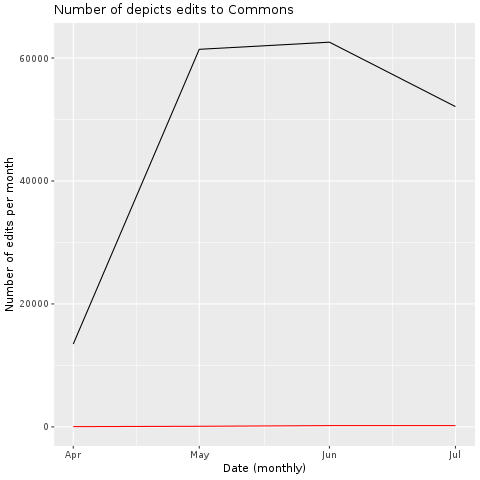

In [47]:
%%R -i depict_edits

## Let's make a graph!
depict_edits = data.table(depict_edits)
depict_edits[, log_month := as.Date(log_month)]

ggplot(depict_edits[log_month < '2019-08-01'],
       aes(x = log_month, y = num_edits)) +
ggtitle("Number of depicts edits to Commons") +
scale_x_date('Date (monthly)') +
scale_y_continuous('Number of edits per month') +
geom_line() +
geom_line(aes(y = num_reverts), colour = "red")


In [51]:
depict_edits.loc[depict_edits.num_reverts > 0]

,log_month,num_edits,num_reverts
0,2019-05-01,61417,92
1,2019-07-01,52097,209
2,2019-04-01,13472,37
3,2019-06-01,62577,204


The number of "depicts" edits is huge, but it does not sum up to 500k files having depict statements. This means that if around 500k files on Commons have structured data, there's a lot of other structured data that is added/updated. This latter fact is a strong motivator for me completing the second part of the analysis above, to understand what properties are actually edited.

From looking at the graph it's easy to conclude that the number of reverts is zero, but that is not the case. Instead, there are some reverts. But, compared to the number of edits, it's minimal, on the order of 0.1% or something.

## Number of Commons edits tagged with "Short caption"

These are the edits that add a caption to a file. Similarly as for the app edits to Wikidata above, we want to count these per month.

In [48]:
short_caption_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month,
       COUNT(*) AS num_edits,
       SUM(IF(revision_is_identity_reverted = TRUE
              AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverts
FROM wmf.mediawiki_history
WHERE snapshot = "2019-07"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2017-01-01"
AND array_contains(revision_tags, "Short caption") = TRUE
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01")
LIMIT 250
'''

In [49]:
short_caption_edits = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    short_caption_query])

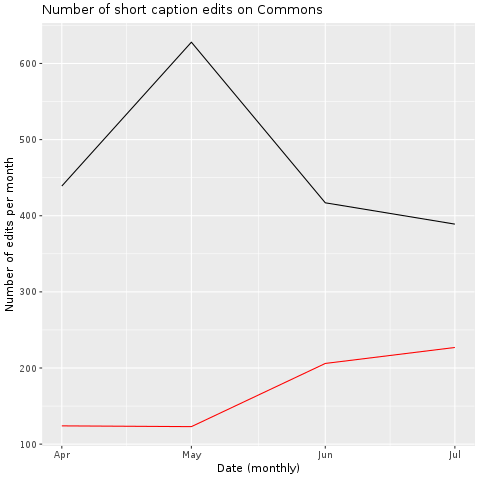

In [52]:
%%R -i short_caption_edits

## Let's make a graph!
short_caption_edits = data.table(short_caption_edits)
short_caption_edits[, log_month := as.Date(log_month)]

ggplot(short_caption_edits[log_month < '2019-08-01'],
       aes(x = log_month, y = num_edits)) +
ggtitle("Number of short caption edits on Commons") +
scale_x_date('Date (monthly)') +
scale_y_continuous('Number of edits per month') +
geom_line() +
geom_line(aes(y = num_reverts), colour = "red")

Compared to the other graphs we've seen, it's clear that short captions are not in widespread use on Commons, but they are being edited. The high revert rate is a concern, though. In April and May, the revert rate was in the 15–25% range, but in June and July it has instead been around 50%. This suggests that we want to look into what kind of edits these are, how they are made, and who makes them. What would cause such a high revert rate?

Digging further into this, for instance by quickly looking at [edits tagged with "Short caption"](https://commons.wikimedia.org/w/index.php?hidebots=1&translations=filter&hidecategorization=1&hideWikibase=1&tagfilter=Short+caption&limit=500&days=7&title=Special:RecentChanges&urlversion=2) it seems clear that these are caption edits with not a lot of information (e.g. just a single word or maybe two). The high revert rate therefore makes total sense.

## Number of caption edits

These are edits to Commons that either add or change the "caption" property. Similarly as for the Wikidata app edits above, we count these on a monthly basis.

In [53]:
caption_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month,
       COUNT(*) AS num_edits,
       SUM(IF(revision_is_identity_reverted = TRUE
              AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverts
FROM wmf.mediawiki_history
WHERE snapshot = "2019-07"
AND wiki_db = "commonswiki"
AND event_entity = "revision"
AND event_type = "create"
AND event_timestamp >= "2019-01-01"
AND event_timestamp < "2019-08-01"
AND event_comment REGEXP "^...wbsetlabel-(add|set|remove):"
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01")
LIMIT 250
'''

In [54]:
caption_edits = hive.run([
    "SET mapreduce.map.memory.mb=4096",
    caption_query])

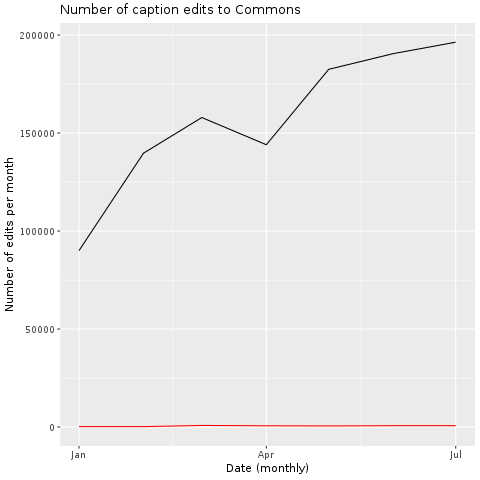

In [55]:
%%R -i caption_edits

## Let's make a graph!
caption_edits = data.table(caption_edits)
caption_edits[, log_month := as.Date(log_month)]

ggplot(caption_edits[log_month < '2019-08-01'],
       aes(x = log_month, y = num_edits)) +
ggtitle("Number of caption edits to Commons") +
scale_x_date('Date (monthly)') +
scale_y_continuous('Number of edits per month') +
geom_line() +
geom_line(aes(y = num_reverts), colour = "red")


In [56]:
## How many reverts are there, really?
caption_edits

,log_month,num_edits,num_reverts
0,2019-01-01,90015,214
1,2019-03-01,157930,799
2,2019-05-01,182541,544
3,2019-07-01,196382,674
4,2019-02-01,139744,201
5,2019-04-01,144051,627
6,2019-06-01,190551,678


Looking at the graph it's clear where the massive number of files with structured data comes from. It's also clear that these types of edits are rarely reverted, it might that it's cheaper to just remove the caption (meaning "revert" in this case means an add followed by a delete of the same language).

## Age of users making micro-contributions

We want to know what the age of users making these types of contributions are, and whether that changes over time (e.g. are users who make micro-contributions now newer to the movement?) To answer this question, we gather data on when users made their first edit to any wiki. This means we will assume that accounts are aligned properly and usernames can be used to identify a user across wikis. We then identify when they made their *first* micro-contribution edit and use the difference between the two to measure the account age.

We will also measure account age on the respective wikis (Wikidata or Commons), because that is used to label users as new or existing active editors. Then, we plot percentiles for either of these across time.

In [95]:
## For the micro-contribution, we want the user ID, user name, timestamp, account age at that time, etc...
## So there we might want to use a windowing function over user because it's a relatively small data set
## We also want to know if the user was then labelled as a bot, and whether they were ever labelled as a bot.

## For Wikidata, we ignore app edits by the Wikimedia Commons app, because there are too few of them to
## have a meaningful impact on our results.
wikidata_age_query = '''
WITH
micro_first AS (
  SELECT event_user_id AS user_id,
    event_user_text AS user_name,
    event_timestamp AS micro_first_edit_ts,
    event_user_creation_timestamp AS local_creation_ts,
    IF(SIZE(event_user_is_bot_by) > 0, 1, 0) AS is_bot_currently,
    IF(SIZE(event_user_is_bot_by_historical) > 0, 1, 0) AS is_bot_historical
  FROM (
    SELECT event_user_id, event_user_text, event_user_creation_timestamp,
      event_timestamp, event_user_is_bot_by, event_user_is_bot_by_historical, 
      ROW_NUMBER() OVER(PARTITION BY event_user_id ORDER BY event_timestamp) AS row_num
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "wikidatawiki"
    AND event_timestamp >= "{start_ts}"
    AND event_timestamp < "{end_ts}"
    AND array_contains(revision_tags, "mobile app edit") = TRUE) AS mce
  WHERE mce.row_num = 1
  ),
global_first AS (
  SELECT event_user_text, MIN(event_user_creation_timestamp) AS global_creation_ts
  FROM wmf.mediawiki_history
  WHERE snapshot = "{snapshot}"
  AND event_entity = "revision"
  AND event_type = "create"
  GROUP BY event_user_text
  )
FROM micro_first JOIN global_first
ON micro_first.user_name = global_first.event_user_text
SELECT user_id, user_name, micro_first_edit_ts, local_creation_ts, global_creation_ts,
  is_bot_currently, is_bot_historical,
  (unix_timestamp(micro_first_edit_ts) - unix_timestamp(global_creation_ts)) AS global_age,
  (unix_timestamp(micro_first_edit_ts) - unix_timestamp(local_creation_ts)) AS local_age
'''

In [96]:
wikidata_ages = hive.run(wikidata_age_query.format(
    snapshot = "2019-07",
    start_ts = "2017-01-01",
    end_ts = "2019-08-01"
))

In [ ]:
wikidata_ages.head()

In [132]:
## parse the timestamps
def parse_age_timestamps(df):
    df['micro_first_edit_ts'] = pd.to_datetime(df['micro_first_edit_ts'],
                                               format = "%Y-%m-%d %H:%M:%S.0", utc = False)
    df['local_creation_ts'] = pd.to_datetime(df['local_creation_ts'],
                                             format = "%Y-%m-%d %H:%M:%S.0", utc = False)
    df['global_creation_ts'] = pd.to_datetime(df['global_creation_ts'],
                                              format = "%Y-%m-%d %H:%M:%S.0", utc = False)
    return(df)

wikidata_ages = parse_age_timestamps(wikidata_ages)

In [106]:
def calc_age_percentiles(df, start_date, end_date, percentiles = [.1, .25, .5, .75, .9]):
    '''
    For the given `pandas.DataFrame` `df` containing information on global and local account age
    at time of a micro-contribution edit, and for each month between the given start and end dates,
    calculate the given `percentiles` for both global and local account age and return a `pandas.DataFrame`
    with the result.
    
    Note that users who are either currently or historically labelled as bots are filtered out.
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type (local/global), percentile (as a string), and age
    res_df = pd.DataFrame(columns = ['log_month', 'age_type', 'percentile', 'age'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        users = df.loc[(df.is_bot_currently == 0) &
                       (df.is_bot_historical == 0) &
                       (df.micro_first_edit_ts >= date_range[month_idx]) &
                       (df.micro_first_edit_ts < date_range[month_idx + 1])]

        age_type = 'global'
        for (percentile, age) in users.global_age.quantile(percentiles).iteritems():
            res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], age_type, "{0:.2f}".format(percentile), age]],
                             columns = ['log_month', 'age_type', 'percentile', 'age']
                )
            )

        age_type = 'local'
        for (percentile, age) in users.local_age.quantile(percentiles).iteritems():
            res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], age_type, "{0:.2f}".format(percentile), age]],
                             columns = ['log_month', 'age_type', 'percentile', 'age']
                )
            )
            
    return(res_df)    

In [119]:
age_percentiles = calc_age_percentiles(wikidata_ages, '2017-01-01', '2019-08-01')

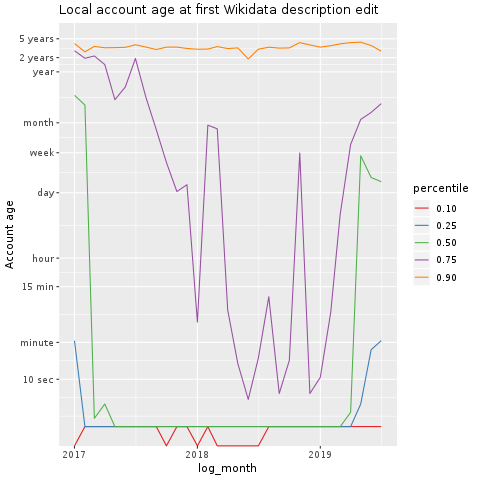

In [124]:
%%R -i age_percentiles

age_percentiles = data.table(age_percentiles)
age_percentiles[, log_month := as.Date(log_month)]

ggplot(age_percentiles[age_type == 'local'],
       aes(x = log_month, y = age, color = percentile)) +
ggtitle("Local account age at first Wikidata description edit") +
scale_y_log10(
  "Account age",
  breaks=c(10, 60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 356*24*60*60, 2*356*24*60*60, 5*356*24*60*60),
  labels=c("10 sec", "minute", "15 min", "hour", "day", "week", "month", "year", "2 years", "5 years")) +
scale_colour_brewer(palette = "Set1") +
geom_line()

From the graph we see that a large proportion of users have an account age of less than 10 seconds when they make their first description edit. This indicates that the system created their account right as they were making the edit, which also means that they already had an account on a different wiki.

Secondly, we see that the 90th percentile are consistently old accounts, between 2–5 years, so there's consistently some oldtimers who start making description edits.

Lastly, we see a change in the trend in the second quarter of 2019. The Median and 25th percentile shoot up, with the median suddenly being between a day and a week. Could this be due to the description edit recommendations?

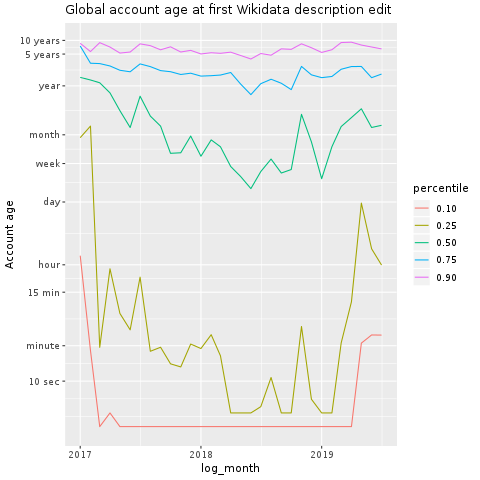

In [127]:
%%R -i age_percentiles

age_percentiles = data.table(age_percentiles)
age_percentiles[, log_month := as.Date(log_month)]

ggplot(age_percentiles[age_type == 'global'],
       aes(x = log_month, y = age, color = percentile)) +
ggtitle("Global account age at first Wikidata description edit") +
scale_y_log10(
  "Account age",
  breaks=c(10, 60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 356*24*60*60,
           5*356*24*60*60, 10*356*24*60*60),
  labels=c("10 sec", "minute", "15 min", "hour", "day", "week", "month", "year",
           "5 years", "10 years")) +
geom_line()

I'm unsure how to interpret this graph. When it comes to the short timespans for the 10th and 25th percentile, I'm wondering if that's largely due to measurement issues and how percentiles are calculated in Pandas.

We see again the change in trend in the second quarter of 2019, with the 25th percentile moving up from seconds to between an hour and a day. Not sure if this is because of the availability of recommendations or other things.

### Age of Commons contributors

Let's repeat the same analysis for users who make "depicts" and "caption" edits to Commons, to get a sense whether those are old or young accounts.

In [128]:
## This is the same query as for Wikidata, but adapted to identify depicts edits to Commons

depicts_age_query = '''
WITH
micro_first AS (
  SELECT event_user_id AS user_id,
    event_user_text AS user_name,
    event_timestamp AS micro_first_edit_ts,
    event_user_creation_timestamp AS local_creation_ts,
    IF(SIZE(event_user_is_bot_by) > 0, 1, 0) AS is_bot_currently,
    IF(SIZE(event_user_is_bot_by_historical) > 0, 1, 0) AS is_bot_historical
  FROM (
    SELECT event_user_id, event_user_text, event_user_creation_timestamp,
      event_timestamp, event_user_is_bot_by, event_user_is_bot_by_historical, 
      ROW_NUMBER() OVER(PARTITION BY event_user_id ORDER BY event_timestamp) AS row_num
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_timestamp >= "{start_ts}"
    AND event_timestamp < "{end_ts}"
    AND event_comment REGEXP "^...wbsetclaim-(create|update).*?Special:EntityPage/P180") AS mce
  WHERE mce.row_num = 1
  ),
global_first AS (
  SELECT event_user_text, MIN(event_user_creation_timestamp) AS global_creation_ts
  FROM wmf.mediawiki_history
  WHERE snapshot = "{snapshot}"
  AND event_entity = "revision"
  AND event_type = "create"
  GROUP BY event_user_text
  )
FROM micro_first JOIN global_first
ON micro_first.user_name = global_first.event_user_text
SELECT user_id, user_name, micro_first_edit_ts, local_creation_ts, global_creation_ts,
  is_bot_currently, is_bot_historical,
  (unix_timestamp(micro_first_edit_ts) - unix_timestamp(global_creation_ts)) AS global_age,
  (unix_timestamp(micro_first_edit_ts) - unix_timestamp(local_creation_ts)) AS local_age
'''

In [130]:
depicts_ages = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
    depicts_age_query.format(
        snapshot = "2019-07",
        start_ts = "2019-01-01",
        end_ts = "2019-08-01")
])

In [133]:
depicts_ages = parse_age_timestamps(depicts_ages)

In [134]:
depicts_percentiles = calc_age_percentiles(depicts_ages, '2019-01-01', '2019-08-01')

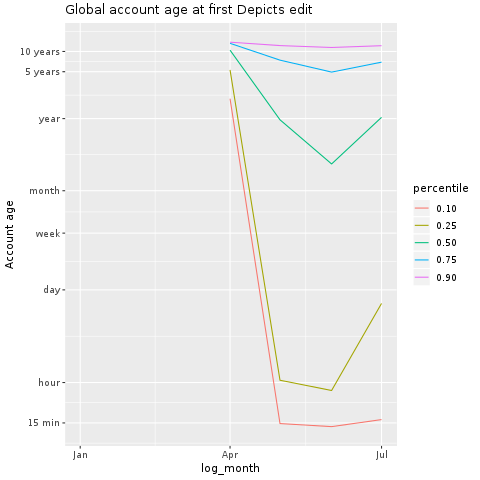

In [135]:
%%R -i depicts_percentiles

depicts_percentiles = data.table(depicts_percentiles)
depicts_percentiles[, log_month := as.Date(log_month)]

ggplot(depicts_percentiles[age_type == 'global'],
       aes(x = log_month, y = age, color = percentile)) +
ggtitle("Global account age at first Depicts edit") +
scale_y_log10(
  "Account age",
  breaks=c(10, 60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 356*24*60*60,
           5*356*24*60*60, 10*356*24*60*60),
  labels=c("10 sec", "minute", "15 min", "hour", "day", "week", "month", "year",
           "5 years", "10 years")) +
geom_line()

We see a similar dropping trend after release as for the description edits. The 10th and 25th percentiles sit somewhere below one day, while we see the median is month to year. This means that while we do have some newer users, the group appears to largely consist of fairly experienced Wikipedians.

If we see younger accounts in the Caption edits, it might be that users start off with those and then move on to depicts edits. It also seems clear that we need to carefully combine the two groups.

In [136]:
## This is the same query as above, but changed to identify caption edits.

captions_age_query = '''
WITH
micro_first AS (
  SELECT event_user_id AS user_id,
    event_user_text AS user_name,
    event_timestamp AS micro_first_edit_ts,
    event_user_creation_timestamp AS local_creation_ts,
    IF(SIZE(event_user_is_bot_by) > 0, 1, 0) AS is_bot_currently,
    IF(SIZE(event_user_is_bot_by_historical) > 0, 1, 0) AS is_bot_historical
  FROM (
    SELECT event_user_id, event_user_text, event_user_creation_timestamp,
      event_timestamp, event_user_is_bot_by, event_user_is_bot_by_historical, 
      ROW_NUMBER() OVER(PARTITION BY event_user_id ORDER BY event_timestamp) AS row_num
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_timestamp >= "{start_ts}"
    AND event_timestamp < "{end_ts}"
    AND event_comment REGEXP "^...wbsetlabel-(add|set|remove):") AS mce
  WHERE mce.row_num = 1
  ),
global_first AS (
  SELECT event_user_text, MIN(event_user_creation_timestamp) AS global_creation_ts
  FROM wmf.mediawiki_history
  WHERE snapshot = "{snapshot}"
  AND event_entity = "revision"
  AND event_type = "create"
  GROUP BY event_user_text
  )
FROM micro_first JOIN global_first
ON micro_first.user_name = global_first.event_user_text
SELECT user_id, user_name, micro_first_edit_ts, local_creation_ts, global_creation_ts,
  is_bot_currently, is_bot_historical,
  (unix_timestamp(micro_first_edit_ts) - unix_timestamp(global_creation_ts)) AS global_age,
  (unix_timestamp(micro_first_edit_ts) - unix_timestamp(local_creation_ts)) AS local_age
'''

In [138]:
caption_ages = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
    captions_age_query.format(
        snapshot = "2019-07",
        start_ts = "2019-01-01",
        end_ts = "2019-08-01")
])

In [139]:
caption_ages = parse_age_timestamps(caption_ages)

In [140]:
caption_percentiles = calc_age_percentiles(caption_ages, '2019-01-01', '2019-08-01')

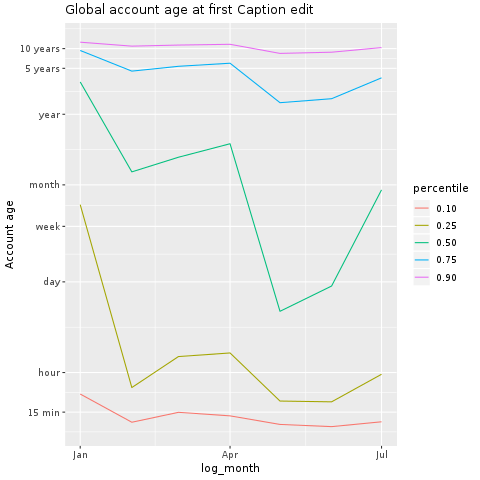

In [141]:
%%R -i caption_percentiles

caption_percentiles = data.table(caption_percentiles)
caption_percentiles[, log_month := as.Date(log_month)]

ggplot(caption_percentiles[age_type == 'global'],
       aes(x = log_month, y = age, color = percentile)) +
ggtitle("Global account age at first Caption edit") +
scale_y_log10(
  "Account age",
  breaks=c(10, 60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 356*24*60*60,
           5*356*24*60*60, 10*356*24*60*60),
  labels=c("10 sec", "minute", "15 min", "hour", "day", "week", "month", "year",
           "5 years", "10 years")) +
geom_line()

I think there are two trends going on here. First, we see the initial release in January and how the lower percentiles drop as part of that. Then, the second trend happens after release of Depicts edits in April, where the trend drops in May and June.

Again, I see this and the previous graph in combination, finding that it's important to combine the two to look at "micro-contribution users" rather than these types of edits separately.